In [2]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [3]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [4]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [5]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [6]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [7]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [8]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
0,2021-10-31,19153,Polk County,IA,59.7,292772,64.9,317999.0
1,2021-10-31,1007,Bibb County,AL,31.0,6939,38.2,8546.0
2,2021-10-31,18161,Union County,IN,45.1,3179,48.8,3442.0
3,2021-10-31,46059,Hand County,SD,42.9,1370,45.9,1466.0
4,2021-10-31,18065,Henry County,IN,48.0,23050,51.5,24698.0
...,...,...,...,...,...,...,...,...
1060095,2020-12-13,36087,Rockland County,NY,0.0,0,0.0,0.0
1060096,2020-12-13,40137,Stephens County,OK,0.0,0,0.0,0.0
1060097,2020-12-13,35017,Grant County,NM,0.0,0,0.0,0.0
1060098,2020-12-13,48429,Stephens County,TX,0.0,0,0.0,0.0


<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [9]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [10]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [11]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [12]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

,state,Date,short_staffed,got_covid_at_hosp,total_beds,beds_used,covid_beds_used,icu_occupancy,covid_icu,covid_beds_adult,covid_beds_kids,icu_total,beds_used_pct,covid_patients_pct,covid_beds_pct,icu_used,icu_used_pct,therapy_a,therapy_b,therapy_b
30306,MT,2020-01-01,0.0,0.0,36.0,12.0,0.0,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
32505,PR,2020-01-01,0.0,0.0,146.0,61.0,0.0,NaN,NaN,NaN,NaN,NaN,0.417808,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
28765,MN,2020-01-01,0.0,0.0,46.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25421,HI,2020-01-01,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28320,IN,2020-01-01,0.0,0.0,30.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24956,MT,2021-10-31,10.0,3.0,3032.0,2266.0,418.0,188.0,113.0,396.0,22.0,228.0,0.747361,0.185530,0.139194,0.509009,0.824561,1453.0,819.0,694.0
17574,WV,2021-10-31,26.0,8.0,5960.0,4628.0,655.0,513.0,184.0,650.0,5.0,672.0,0.776510,0.144560,0.112931,0.290679,0.763393,42.0,0.0,8.0
13040,IL,2021-10-31,12.0,7.0,30512.0,21829.0,1203.0,2160.0,286.0,1161.0,42.0,3240.0,0.715423,0.055733,0.039907,0.090192,0.666667,5842.0,3999.0,2272.0
18901,MD,2021-10-31,3.0,7.0,9336.0,8056.0,703.0,754.0,160.0,690.0,13.0,1042.0,0.862896,0.087952,0.076148,0.159363,0.723608,1120.0,605.0,1441.0


<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [13]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.0
71.2


,level_0,index,Date,tier,population,total_vaccinated_count,first_dose_count,tot_confirm,tot_death,New_Cases,New_Deaths,case_7_day_avg,death_7_day_avg,case_avg_100k,death_avg_100k,total_vaccinated_percent,first_dose_pct
0,0,0,2020-12-28,total_40,9061156,0,0,610047,7757,7479,92,12295.142857,162.000000,135.690665,1.787851,0.000000,0.000000
1,1,0,2020-12-29,total_40,9061156,0,0,617024,7819,11271,147,12247.571429,164.500000,135.165661,1.815442,0.000000,0.000000
2,2,0,2020-12-30,total_40,9061156,0,0,625042,7900,14995,143,12320.785714,160.357143,135.973663,1.769721,0.000000,0.000000
3,3,0,2020-12-31,total_40,9061156,0,0,632046,8039,15022,220,12324.714286,157.714286,136.017019,1.740554,0.000000,0.000000
4,4,0,2021-01-01,total_40,9061156,0,0,639053,8107,14011,207,12128.357143,157.000000,133.849998,1.732671,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,303,0,2021-10-27,total_40,9061156,3950722,4699348,1488614,24453,13486,177,7269.071429,178.142857,80.222341,1.966006,0.436006,0.518626
304,304,0,2021-10-28,total_40,9061156,3956526,4706765,1493070,24576,14600,189,7636.000000,167.000000,84.271808,1.843032,0.436647,0.519444
305,305,0,2021-10-29,total_40,9061156,3962017,4713488,1495947,24666,7333,213,7491.142857,158.214286,82.673147,1.746072,0.437253,0.520186
306,306,0,2021-10-30,total_40,9061156,3966870,4719631,1497702,24711,4632,135,7304.285714,155.214286,80.610970,1.712963,0.437789,0.520864


- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [14]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 54, 56], 'state': ['AL', 'ID', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 28, 29, 38, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MS', 'MO', 'ND', 'TN']}, 50: {'FIPS': [4, 20, 21, 26, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'KS', 'KY', 'MI', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [10, 12, 19, 27, 31, 55], 'state': ['DE', 'FL', 'IA', 'MN', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 17, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'IL', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 25, 34, 36], 'state': ['MD', 'MA', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 44, 50], 'state': ['CT', 'ME', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889,6592849,2021-10-27,13121,722325,2790,64,2408.428571,36.530923,27.857143,0.422536,CT,"[9, 23, 44, 50]",total_70,15417.0,12330.0,585.0,1629.0,0.487465883784825,157.0,575.0,10.0,36.530923,0.422536
3890,6592849,2021-10-28,13128,723930,2984,28,2412.285714,36.589428,29.000000,0.439871,CT,"[9, 23, 44, 50]",total_70,15456.0,12382.0,572.0,1615.0,0.5258930176774,160.0,564.0,8.0,36.589428,0.439871
3891,6592849,2021-10-29,13148,725447,3122,27,2425.285714,36.786611,28.571429,0.43337,CT,"[9, 23, 44, 50]",total_70,15373.0,12272.0,565.0,1614.0,0.507313690796838,158.0,560.0,5.0,36.786611,0.43337
3892,6592849,2021-10-30,13152,726170,2240,24,2418.142857,36.678268,27.571429,0.418202,CT,"[9, 23, 44, 50]",total_70,15373.0,12200.0,557.0,1613.0,0.500572179160266,158.0,552.0,5.0,36.678268,0.418202


<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [15]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count,tier
334,2020-12-21,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,1050394,17866,16938,115,23582.000000,289.571429,125.208517,1.537478,100,1.537478,0.0,0,0.0,0.0,total_30
335,2020-12-22,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,1064540,18082,21443,266,23690.714286,290.571429,125.785735,1.542788,100,1.542788,0.0,0,0.0,0.0,total_30
336,2020-12-23,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,1077595,18291,27201,425,23818.000000,295.714286,126.461558,1.570094,100,1.570094,0.0,0,0.0,0.0,total_30
337,2020-12-24,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,1092284,18474,27744,392,23953.571429,294.428571,127.181374,1.563267,100,1.563267,0.0,0,0.0,0.0,total_30
338,2020-12-25,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,1100200,18579,22605,288,23104.857143,288.571429,122.675129,1.532169,100,1.532169,0.0,0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2021-10-27,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3162054,52198,7605,96,6733.142857,72.285714,24.623092,0.264349,24.623092,0.264349,73.049704,19975318,81.584242,22309073.0,total_70
645,2021-10-28,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3165634,52235,6846,79,6662.142857,70.428571,24.363445,0.257557,24.363445,0.257557,73.132088,19997846,81.70772,22342838.0,total_70
646,2021-10-29,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3171815,52280,9761,82,6743.000000,69.285714,24.659139,0.253378,24.659139,0.253378,73.201729,20016889,81.81585,22372406.0,total_70
647,2021-10-30,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3172871,52277,7237,42,6802.714286,67.142857,24.877514,0.245541,24.877514,0.245541,73.269113,20035315,81.919033,22400621.0,total_70


In [16]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
16,2020-02-07,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
17,2020-02-08,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
18,2020-02-09,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
19,2020-02-10,"[1007, 5067, 16045, 29143, 28019, 48067, 48143...",Bibb,Alabama,"Bibb, Alabama, US",18834182,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2021-10-27,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3162054,52198,7605,96,6733.142857,72.285714,24.623092,0.264349,24.623092,0.264349,total_70
645,2021-10-28,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3165634,52235,6846,79,6662.142857,70.428571,24.363445,0.257557,24.363445,0.257557,total_70
646,2021-10-29,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3171815,52280,9761,82,6743.000000,69.285714,24.659139,0.253378,24.659139,0.253378,total_70
647,2021-10-30,"[44005, 55029, 6001, 53055, 8097, 9011, 23031,...",Apache,Arizona,"Apache, Arizona, US",27344831,3172871,52277,7237,42,6802.714286,67.142857,24.877514,0.245541,24.877514,0.245541,total_70


In [17]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

,Date,FIPS,Admin2,Province_State,Combined_Key,Population,tot_confirm,tot_deaths,New_Confirm,New_Deaths,case_7_day_avg,death_7_day_avg,case_100k_avg,death_100k_avg,case_scaled_100k,death_scaled_100k,tier
15,2020-02-06,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
16,2020-02-07,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
17,2020-02-08,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
18,2020-02-09,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
19,2020-02-10,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,total_50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2021-10-27,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,8479627,118069,36209,738,27498.714286,486.285714,47.445029,0.839015,47.445029,0.839015,total_50
645,2021-10-28,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,8494685,118264,35866,656,27982.000000,455.142857,48.278868,0.785283,48.278868,0.785283,total_50
646,2021-10-29,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,8514315,118583,34688,514,28084.428571,444.000000,48.455594,0.766057,48.455594,0.766057,total_50
647,2021-10-30,"[18163, 27041, 48209, 19099, 38073, 49051, 370...",Hale,Alabama,"Hale, Alabama, US",57959105,8519173,118654,24488,390,28061.142857,447.285714,48.415418,0.771726,48.415418,0.771726,total_50


- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [18]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10239.032415
1    10950.639507
2    10577.548955
3    10746.231667
4    10524.512068
5     9676.133212
6    10129.586291
7     9695.806959
8     9270.179801
Name: confirm_period_100k, dtype: float64
9     4896.320955
10    5385.042588
11    5066.800957
12    4315.958631
13    4175.899542
14    3390.296350
15    2780.932032
16    2116.812261
17    2332.934513
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.069499
2    1.033061
3    1.049536
4    1.027882
5    0.945024
6    0.989311
7    0.946946
8    0.905377
Name: confirm_period_100k, dtype: float64
9     1.000000
10    1.099814
11    1.034818
12    0.881470
13    0.852865
14    0.692417
15    0.567964
16    0.432327
17    0.476467
Name: confirm_period_100k, dtype: float64
[ 0.         -0.0303146  -0.0017566   0.16806614  0.17501676  0.25260708
  0.4213473   0.51461852  0.42890972]
0    197.486676
1    208.723779
2    195.775876
3    191.301167
4    167.878714
5    161.214839
6    190.253897
7

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,18834182,0.057774,2020-02-06,2021-06-30,1928438,10239.032415,37195,197.486676
1,0,total_35,start,16823191,0.051605,2020-02-06,2021-06-30,1842247,10950.639507,35114,208.723779
2,0,total_40,start,24700694,0.075769,2020-02-06,2021-06-30,2612728,10577.548955,48358,195.775876
3,0,total_45,start,36024349,0.110505,2020-02-06,2021-06-30,3871260,10746.231667,68915,191.301167
4,0,total_50,start,57959105,0.177790,2020-02-06,2021-06-30,6099913,10524.512068,97301,167.878714
5,0,total_55,start,59083891,0.181240,2020-02-06,2021-06-30,5717036,9676.133212,95252,161.214839
6,0,total_60,start,63854671,0.195874,2020-02-06,2021-06-30,6468214,10129.586291,121486,190.253897
7,0,total_65,start,21373270,0.065563,2020-02-06,2021-06-30,2072311,9695.806959,40756,190.686778
8,0,total_70,start,27344831,0.083880,2020-02-06,2021-06-30,2534915,9270.179801,49650,181.569965


In [19]:
start_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,18834182,0.057774,2020-02-06,2021-06-30,1928438,10239.032415,37195,197.486676
1,0,total_35,start,16823191,0.051605,2020-02-06,2021-06-30,1842247,10950.639507,35114,208.723779
2,0,total_40,start,24700694,0.075769,2020-02-06,2021-06-30,2612728,10577.548955,48358,195.775876
3,0,total_45,start,36024349,0.110505,2020-02-06,2021-06-30,3871260,10746.231667,68915,191.301167
4,0,total_50,start,57959105,0.177790,2020-02-06,2021-06-30,6099913,10524.512068,97301,167.878714
5,0,total_55,start,59083891,0.181240,2020-02-06,2021-06-30,5717036,9676.133212,95252,161.214839
6,0,total_60,start,63854671,0.195874,2020-02-06,2021-06-30,6468214,10129.586291,121486,190.253897
7,0,total_65,start,21373270,0.065563,2020-02-06,2021-06-30,2072311,9695.806959,40756,190.686778
8,0,total_70,start,27344831,0.083880,2020-02-06,2021-06-30,2534915,9270.179801,49650,181.569965


In [20]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count
566,2021-10-31,35031,McKinley County,NM,72.2,51527,90.6,64680.0
6545,2021-10-30,35031,McKinley County,NM,72.1,51450,90.3,64471.0
9269,2021-10-29,35031,McKinley County,NM,72.0,51385,90.2,64343.0
12786,2021-10-28,35031,McKinley County,NM,71.9,51327,89.9,64131.0
16108,2021-10-27,35031,McKinley County,NM,71.8,51245,89.5,63874.0
...,...,...,...,...,...,...,...,...
1046664,2020-12-17,35031,McKinley County,NM,0.0,0,0.0,0.0
1047375,2020-12-16,35031,McKinley County,NM,0.0,0,0.0,0.0
1052914,2020-12-15,35031,McKinley County,NM,0.0,0,0.0,0.0
1053833,2020-12-14,35031,McKinley County,NM,0.0,0,0.0,0.0


# Build Statewide Overview Summary Dictionary #

In [21]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-31 00:00:00'),
  'confirm_period': 888774,
  'confirm_start': 610047,
  'confirm_end': 1498821,
  'confirm_period_100k': 9808.61603089054,
  'confirm_deaths': 16954,
  'death_period_100k': 187.1063692094033,
  'vax_complete': 3969894,
  'vax_complete_100k': 43812.22440050696,
  'vax_partial': 4723536,
  'vax_partial_100k': 52129.507537448866,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 41721053,
  'pop_pct': 0.12751770819271183,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-10-31 00:00:00'),
  'confirm_period': 3739733,
  'confirm_start': 2914236,
  'confirm_end': 6653969,
  'confirm_period_100k': 8963.659186646128,
  'confirm_deaths': 60070,
  'death_period_100k': 143.98006685018234,
  'vax_complete': 20163652,
  'vax_complete_100k': 48329.68142007346,


# Statewide Vax Tier Graphs #

In [22]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0277 confirm 100k:9808 Death 100k:187 Vaccine 100k:43812
total_45 pop pct:0.1275 confirm 100k:8963 Death 100k:143 Vaccine 100k:48329
total_50 pop pct:0.2848 confirm 100k:8592 Death 100k:135 Vaccine 100k:52606
total_55 pop pct:0.1192 confirm 100k:9179 Death 100k:72 Vaccine 100k:59042
total_60 pop pct:0.2945 confirm 100k:6749 Death 100k:105 Vaccine 100k:61177
total_65 pop pct:0.1463 confirm 100k:7352 Death 100k:95 Vaccine 100k:67571


# Build Statewide Overview Summer Summary Dictionary #

In [23]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 9061156,
  'pop_pct': 0.027694839022798394,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-31 00:00:00'),
  'confirm_period': 820248,
  'confirm_start': 678573,
  'confirm_end': 1498821,
  'confirm_period_100k': 9052.354909241161,
  'confirm_deaths': 16107,
  'death_period_100k': 177.75877603255037,
  'vax_complete': 3969894,
  'vax_complete_100k': 43812.22440050696,
  'vax_partial': 4723536,
  'vax_partial_100k': 52129.507537448866,
  'states': ['Alabama', 'Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 41721053,
  'pop_pct': 0.12751770819271183,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-31 00:00:00'),
  'confirm_period': 3407015,
  'confirm_start': 3246954,
  'confirm_end': 6653969,
  'confirm_period_100k': 8166.17691792199,
  'confirm_deaths': 55799,
  'death_period_100k': 133.74302896909145,
  'vax_complete': 20163652,
  'vax_complete_100k': 48329.68142007346,

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [24]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

,tier,period,population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,total_40,start,9061156,0.027847,2020-02-07,2021-06-30,972312,10730.551378,17142,189.181160
0,total_45,start,41721053,0.128220,2020-02-07,2021-06-30,4599062,11023.360316,82022,196.596188
0,total_50,start,93164862,0.286321,2020-02-07,2021-06-30,9717214,10430.127616,165666,177.820260
0,total_55,start,39003045,0.119867,2020-02-07,2021-06-30,4356544,11169.753541,62757,160.902822
0,total_60,start,94569458,0.290637,2020-02-07,2021-06-30,8699526,9199.086242,146687,155.110332
0,total_65,start,41273934,0.126846,2020-02-07,2021-06-30,4307691,10436.831633,107612,260.726298
0,total_70,start,6592849,0.020262,2020-02-07,2021-06-30,595409,9031.133581,12111,183.699035
0,total_40,summer,9061156,0.027847,2021-07-01,2021-10-31,526299,5808.298632,7561,83.444099
0,total_45,summer,41721053,0.128220,2021-07-01,2021-10-31,2051098,4916.218198,25842,61.939952
0,total_50,summer,93164862,0.286321,2021-07-01,2021-10-31,3849039,4131.427791,47571,51.061096


In [25]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10239.032415
1    10950.639507
2    10577.548955
3    10746.231667
4    10524.512068
5     9676.133212
6    10129.586291
7     9695.806959
8     9270.179801
Name: confirm_period_100k, dtype: float64
9     4896.320955
10    5385.042588
11    5066.800957
12    4315.958631
13    4175.899542
14    3390.296350
15    2780.932032
16    2116.812261
17    2332.934513
Name: confirm_period_100k, dtype: float64
0    0.478202
1    0.491756
2    0.479015
3    0.401625
4    0.396778
5    0.350377
6    0.274536
7    0.218322
8    0.251660
dtype: float64
0    0.370991
1    0.351939
2    0.340192
3    0.259465
4    0.219104
5    0.168721
6    0.101222
7    0.074492
8    0.052769
dtype: float64



In [26]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [27]:
county_summary_df

,index,tier,period,Population,pop_pct,date_start,date_end,confirm_period,confirm_period_100k,confirm_deaths,death_period_100k
0,0,total_30,start,18834182,0.057883,2020-02-06,2021-06-30,1928438,10239.032415,37195,197.486676
1,0,total_35,start,16823191,0.051702,2020-02-06,2021-06-30,1842247,10950.639507,35114,208.723779
2,0,total_40,start,24700694,0.075912,2020-02-06,2021-06-30,2612728,10577.548955,48358,195.775876
3,0,total_45,start,36024349,0.110713,2020-02-06,2021-06-30,3871260,10746.231667,68915,191.301167
4,0,total_50,start,57959105,0.178124,2020-02-06,2021-06-30,6099913,10524.512068,97301,167.878714
5,0,total_55,start,59083891,0.181581,2020-02-06,2021-06-30,5717036,9676.133212,95252,161.214839
6,0,total_60,start,63854671,0.196243,2020-02-06,2021-06-30,6468214,10129.586291,121486,190.253897
7,0,total_65,start,21373270,0.065686,2020-02-06,2021-06-30,2072311,9695.806959,40756,190.686778
8,0,total_70,start,27344831,0.084038,2020-02-06,2021-06-30,2534915,9270.179801,49650,181.569965
9,0,total_30,summer,18834182,0.057883,2021-07-01,2021-10-31,922182,4896.320955,13799,73.265725


In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
321        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
320        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
319        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
318        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
317        1      1  Alabama  POLYGON ((-88.46866 31.89

In [29]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

,Date,FIPS,Recip_County,Recip_State,total_vaccinated_percent,total_vaccinated_count,first_dose_pct,first_dose_count,tier
0,2021-10-31,19153,Polk County,IA,59.7,292772,64.9,317999.0,total_55
1,2021-10-30,19153,Polk County,IA,59.7,292768,64.9,317968.0,total_55
2,2021-10-29,19153,Polk County,IA,59.7,292458,64.8,317602.0,total_55
3,2021-10-28,19153,Polk County,IA,59.6,292161,64.7,317287.0,total_55
4,2021-10-27,19153,Polk County,IA,59.5,291875,64.7,316923.0,total_55
...,...,...,...,...,...,...,...,...,...
1001179,2020-12-17,46119,Sully County,SD,0.0,0,0.0,0.0,total_35
1001180,2020-12-16,46119,Sully County,SD,0.0,0,0.0,0.0,total_35
1001181,2020-12-15,46119,Sully County,SD,0.0,0,0.0,0.0,total_35
1001182,2020-12-14,46119,Sully County,SD,0.0,0,0.0,0.0,total_35


- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

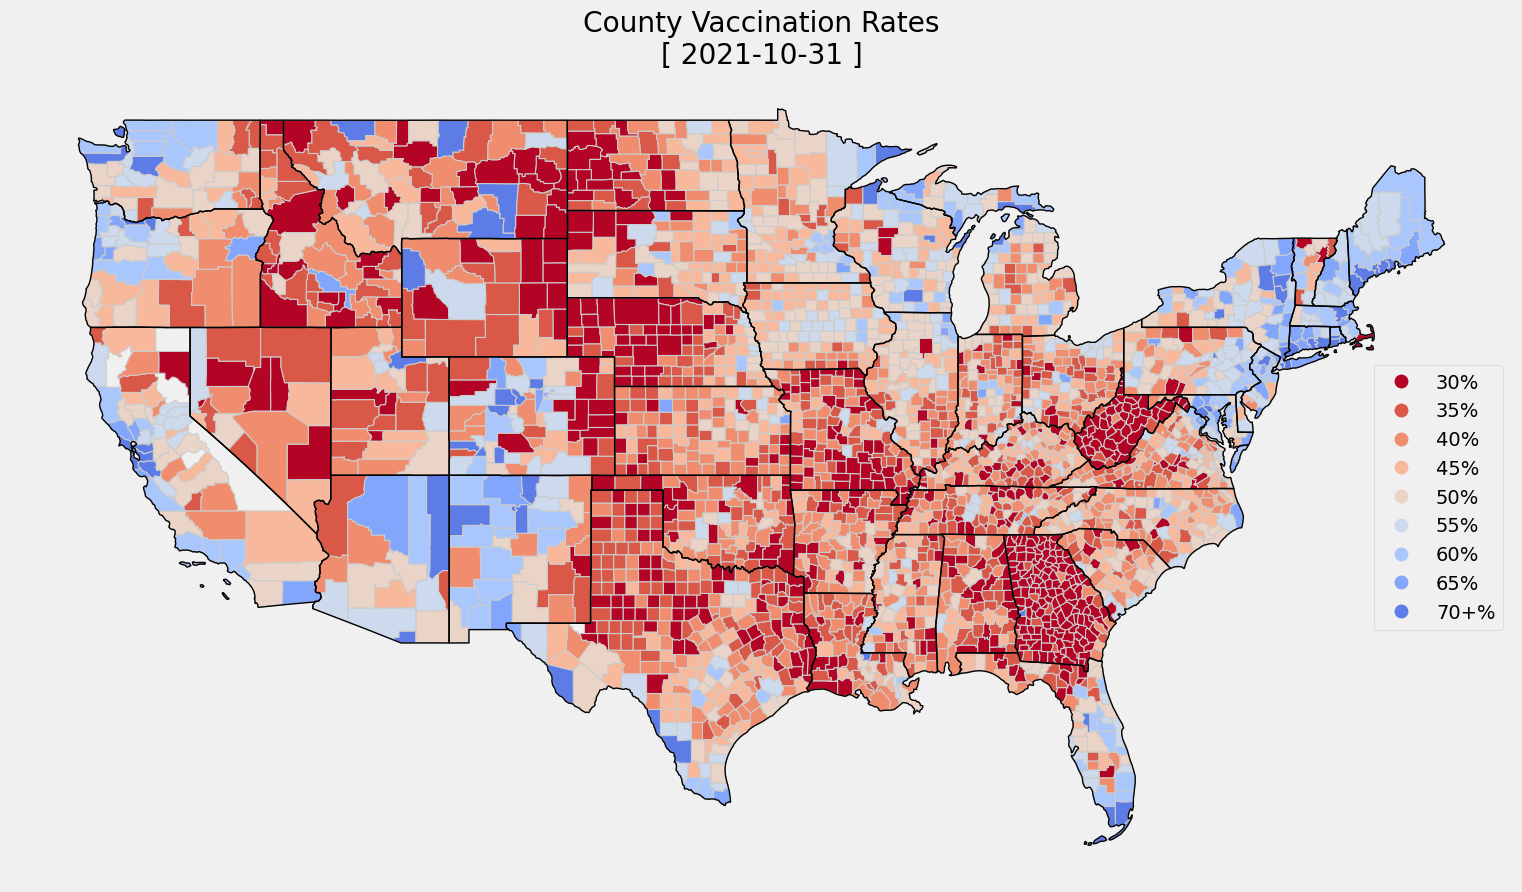

In [45]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


#outfilename=f'z_blog_natl_county_vax.jpg'
#out_blog_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")





In [31]:
geo_county_tier_df

,STATEFP,GEOID,NAME,geometry,FIPS,tier
0,37,37017,Bladen,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",37017,total_40
1,37,37167,Stanly,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",37167,total_35
2,39,39153,Summit,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",39153,total_55
3,42,42113,Sullivan,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",42113,total_45
4,48,48459,Upshur,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",48459,total_30
...,...,...,...,...,...,...
3094,22,22003,Allen,"POLYGON ((-93.13029 30.59789, -92.97917 30.598...",22003,total_30
3095,38,38005,Benson,"POLYGON ((-99.84661 48.37130, -99.49292 48.370...",38005,total_45
3096,31,31159,Seward,"POLYGON ((-97.36812 41.04695, -96.91094 41.046...",31159,total_45
3097,37,37023,Burke,"POLYGON ((-81.90665 35.88338, -81.94319 35.960...",37023,total_40


In [32]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 122


{'start_daily_100k_confirm': 0    10239
 1    10950
 2    10577
 3    10746
 4    10524
 5     9676
 6    10129
 7     9695
 8     9270
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9270,
 'start_daily_100k_confirm_max': 10950,
 'start_daily_mean_confirm': 0     3773.851272
 1     3605.180039
 2     5112.970646
 3     7575.851272
 4    11937.207436
 5    11187.937378
 6    12657.953033
 7     4055.403131
 8     4960.694716
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7558.868852
 10     7425.704918
 11    10258.483607
 12    12744.229508
 13    19838.639344
 14    16419.008197
 15    14555.368852
 16     3708.459016
 17     5228.991803
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     72.788650
 1     68.716243
 2     94.634051
 3    134.863014
 4    190.412916
 5    186.403131
 6    237.741683
 7     79.757339
 8     97.162427
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     113.1

In [33]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10239
 1    10950
 2    10577
 3    10746
 4    10524
 5     9676
 6    10129
 7     9695
 8     9270
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 9270,
 'start_daily_100k_confirm_max': 10950,
 'start_daily_mean_confirm': 0     3773.851272
 1     3605.180039
 2     5112.970646
 3     7575.851272
 4    11937.207436
 5    11187.937378
 6    12657.953033
 7     4055.403131
 8     4960.694716
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 9      7558.868852
 10     7425.704918
 11    10258.483607
 12    12744.229508
 13    19838.639344
 14    16419.008197
 15    14555.368852
 16     3708.459016
 17     5228.991803
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     72.788650
 1     68.716243
 2     94.634051
 3    134.863014
 4    190.412916
 5    186.403131
 6    237.741683
 7     79.757339
 8     97.162427
 Name: confirm_deaths, dtype: float64,
 'summer_daily_mean_death': 9     113.1

In [34]:
state_hosp_tiers_df

,population,Date,tot_death,tot_confirm,New_Cases,New_Deaths,case_7_day_avg,case_avg_100k,death_7_day_avg,death_avg_100k,loc,FIPS,tier,total_beds,beds_used,covid_beds_used,icu_total,icu_used,covid_icu,covid_beds_adult,covid_beds_kids,case_scaled_100k,death_scaled_100k
16,9061156,2020-02-07,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,9061156,2020-02-08,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,9061156,2020-02-09,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,9061156,2020-02-10,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,9061156,2020-02-11,0,0,0,0,0.000000,0.0,0.000000,0.0,AL,"[1, 16, 54, 56]",total_40,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889,6592849,2021-10-27,13121,722325,2790,64,2408.428571,36.530923,27.857143,0.422536,CT,"[9, 23, 44, 50]",total_70,15417.0,12330.0,585.0,1629.0,0.487465883784825,157.0,575.0,10.0,36.530923,0.422536
3890,6592849,2021-10-28,13128,723930,2984,28,2412.285714,36.589428,29.000000,0.439871,CT,"[9, 23, 44, 50]",total_70,15456.0,12382.0,572.0,1615.0,0.5258930176774,160.0,564.0,8.0,36.589428,0.439871
3891,6592849,2021-10-29,13148,725447,3122,27,2425.285714,36.786611,28.571429,0.43337,CT,"[9, 23, 44, 50]",total_70,15373.0,12272.0,565.0,1614.0,0.507313690796838,158.0,560.0,5.0,36.786611,0.43337
3892,6592849,2021-10-30,13152,726170,2240,24,2418.142857,36.678268,27.571429,0.418202,CT,"[9, 23, 44, 50]",total_70,15373.0,12200.0,557.0,1613.0,0.500572179160266,158.0,552.0,5.0,36.678268,0.418202


In [35]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

,Date,Location,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_12PlusPop_Pct,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_18PlusPop_Pct,Administered_Dose1_Recip_65Plus,Administered_Dose1_Recip_65PlusPop_Pct,Series_Complete_Yes,Series_Complete_Pop_Pct,Series_Complete_12Plus,Series_Complete_12PlusPop_Pct,Series_Complete_18Plus,Series_Complete_18PlusPop_Pct,Series_Complete_65Plus,Series_Complete_65PlusPop_Pct
20884,2020-12-13,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20862,2020-12-14,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20784,2020-12-15,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20712,2020-12-16,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
20644,2020-12-17,US,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2021-10-27,US,220936118,66.5,220701498,77.8,205752308,79.7,52869235,96.7,190990750,57.5,190857435,67.3,178406017,69.1,46378477,84.8
208,2021-10-28,US,221348530,66.7,221113746,78.0,206144216,79.8,53014862,96.9,191242432,57.6,191109061,67.4,178635217,69.2,46428087,84.9
144,2021-10-29,US,220860887,66.5,220627819,77.8,205709072,79.7,52968902,96.8,191997869,57.8,191862366,67.7,179314245,69.4,46573398,85.1
99,2021-10-30,US,221221467,66.6,220988245,77.9,206051416,79.8,53090010,97.1,192244927,57.9,192109365,67.8,179540294,69.5,46625041,85.2


- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [36]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8523781350078431,
  0.34649194649411763,
  0.2803464686980392,
  1.0),
 'total_55': (0.9440545734235294, 0.5531534787490197, 0.4355484903137255, 1.0),
 'total_45': (0.968203399, 0.7208441, 0.6122929913333334, 1.0),
 'total_30': (0.9193759889058823, 0.8312727235294118, 0.7828736304470588, 1.0),
 'total_50': (0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0),
 'total_70': (0.6672529243333334, 0.7791764569999999, 0.992959213, 1.0),
 'total_60': (0.5108243242509803, 0.6493966148235294, 0.9850787763764707, 1.0),
 'total_65': (0.3634607953411765, 0.4847836818509804, 0.9010188868941177, 1.0)}

In [37]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [38]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_632.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_632.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_632.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_633.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_633.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_633.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_634.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_634.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_634.jpg
Done...
Done!


In [41]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_4.jpg
C:/Users

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_93.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_94.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_95.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_95.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_95.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_96.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_96.j

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_190.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_191.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_191.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_191.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_192.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_192.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_192.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_193.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_193.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_193.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_291.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_291.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_291.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_292.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_370.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_371.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_371.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_371.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_372.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_372.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_372.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_373.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_373.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_373.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_448.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_448.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_449.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_449.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_449.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_450.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_450.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_450.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_451.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_451.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_526.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_527.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_528.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_529.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_600.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_600.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

In [ ]:
all_dates

In [ ]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [ ]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

In [ ]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

In [ ]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [ ]:
county_tier_df

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [ ]:
geo_county_vax_tier_df['Date'].iloc[1]

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

In [ ]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

In [ ]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




In [ ]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [ ]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

In [ ]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

In [ ]:
manage_df

In [ ]:
whole_county_tier_df

In [ ]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [ ]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [ ]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

In [ ]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [ ]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [ ]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

In [ ]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [ ]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [ ]:
plot_df